In [7]:
import warnings
warnings.filterwarnings('ignore')

import os
import scanpy as sc
import squidpy as sq
import numpy as np
import cell2location
import scvi

In [9]:
if not os.path.exists('../../results/04_spatial/09_run_cell2location'):
    os.makedirs('../../results/04_spatial/09_run_cell2location')

In [10]:
adata_ref = sc.read_h5ad('../../results/03_integrate_scrna/integrated.h5ad')

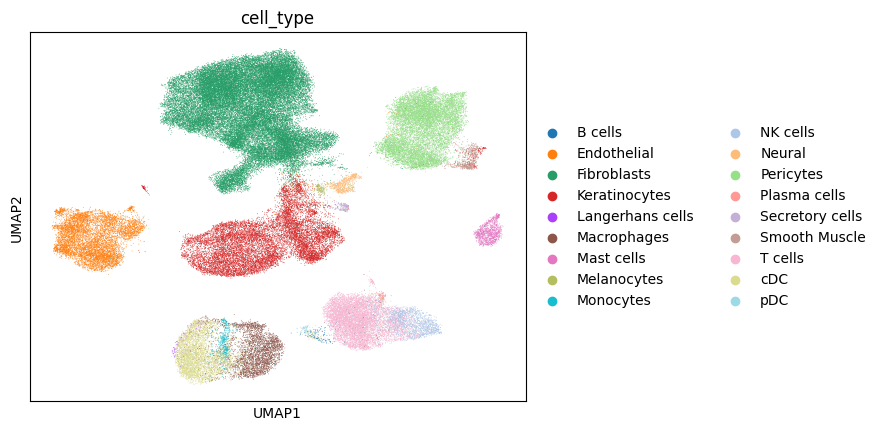

In [12]:
sc.pl.umap(adata_ref, color=['cell_type'])

In [15]:
adata_ref = adata_ref[adata_ref.obs['cell_type'] != 'Secretory cells']

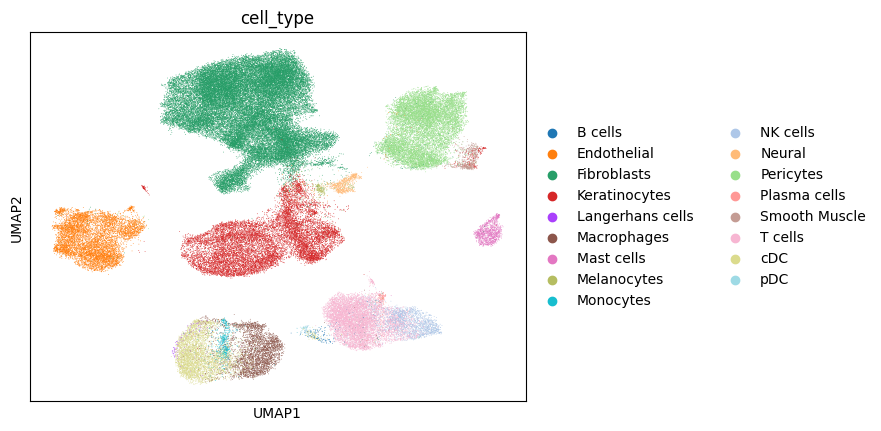

In [16]:
sc.pl.umap(adata_ref, color=['cell_type'])

In [13]:
adata_ref.X = adata_ref.layers['counts'].copy()

In [17]:
cell2location.models.RegressionModel.setup_anndata(adata=adata_ref,
                                                   labels_key='cell_type',
                                                   batch_key='data')

In [18]:
# create the regression model
from cell2location.models import RegressionModel
mod = RegressionModel(adata_ref)

# view anndata_setup as a sanity check
mod.view_anndata_setup()

Anndata setup with scvi-tools version 1.1.5.

Setup via `RegressionModel.setup_anndata` with arguments:

{
│   'layer': None,
│   'batch_key': 'data',
│   'labels_key': 'cell_type',
│   'categorical_covariate_keys': None,
│   'continuous_covariate_keys': None
}

         Summary Statistics         
┏━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━┓
┃     Summary Stat Key     ┃ Value ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━┩
│         n_batch          │   2   │
│         n_cells          │ 95683 │
│ n_extra_categorical_covs │   0   │
│ n_extra_continuous_covs  │   0   │
│         n_labels         │  17   │
│          n_vars          │ 15275 │
└──────────────────────────┴───────┘

               Data Registry                
┏━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Registry Key ┃    scvi-tools Location    ┃
┡━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│      X       │          adata.X          │
│    batch     │ adata.obs['_scvi_batch']  │
│    ind_x     │   adata.obs['_indices']   │
│    labels    │ adata.obs['_scvi_labels'] │
└──────────────┴───────────────────────────┘

                  batch State Registry                  
┏━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┓
┃  Source Location  ┃ Categories ┃ scvi-tools Encoding ┃
┡━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━┩
│ adata.obs['data'] │  Gur2022   │          0          │
│                   │ Tabib2021  │          1          │
└───────────────────┴────────────┴─────────────────────┘

                       labels State Registry                       
┏━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┓
┃    Source Location     ┃    Categories    ┃ scvi-tools Encoding ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━┩
│ adata.obs['cell_type'] │     B cells      │          0          │
│                        │   Endothelial    │          1          │
│                        │   Fibroblasts    │          2          │
│                        │  Keratinocytes   │          3          │
│                        │ Langerhans cells │          4          │
│                        │   Macrophages    │          5          │
│                        │    Mast cells    │          6          │
│                        │   Melanocytes    │          7          │
│                        │    Monocytes     │          8          │
│                        │     NK cells     │          9          │
│                        │      Neural      │         10          │
│                        │    Pericytes     │         11          │
│                        │   Plasma cells   │         12          │
│                        │  Smooth Muscle   │         13          │
│                        │     T cells      │         14          │
│                        │       cDC        │         15          │
│                        │       pDC        │         16          │
└────────────────────────┴──────────────────┴─────────────────────┘

In [20]:
mod.train(max_epochs=250)

Trainer will use only 1 of 2 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=2)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA A100-PCIE-40GB') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Epoch 250/250: 100%|██████████| 250/250 [34:23<00:00,  8.58s/it, v_num=1, elbo_train=3.72e+8]

`Trainer.fit` stopped: `max_epochs=250` reached.


Epoch 250/250: 100%|██████████| 250/250 [34:23<00:00,  8.25s/it, v_num=1, elbo_train=3.72e+8]


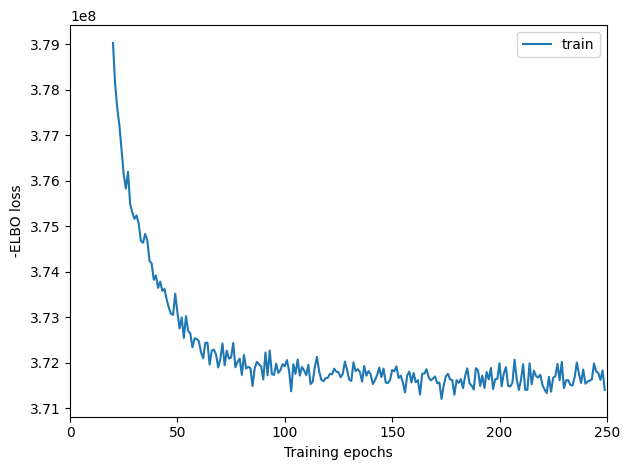

In [21]:
mod.plot_history(20)

In [22]:
# In this section, we export the estimated cell abundance (summary of the posterior distribution).
adata_ref = mod.export_posterior(
    adata_ref, sample_kwargs={'num_samples': 1000, 
                              'batch_size': 2500}
)

Trainer will use only 1 of 2 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=2)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.


Sampling global variables, sample: 100%|██████████| 999/999 [00:08<00:00, 112.48it/s]


In [23]:
# Save model
mod.save(f"../../results/04_spatial/09_run_cell2location", overwrite=True)

# Save anndata object with results
adata_ref.write('../../results/04_spatial/09_run_cell2location/scrna.ref.h5ad')

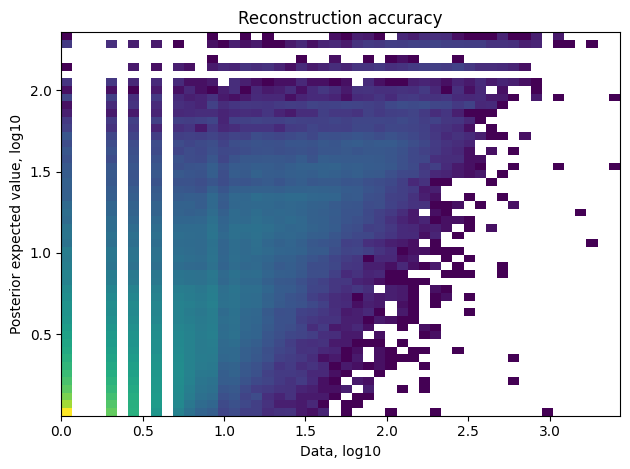

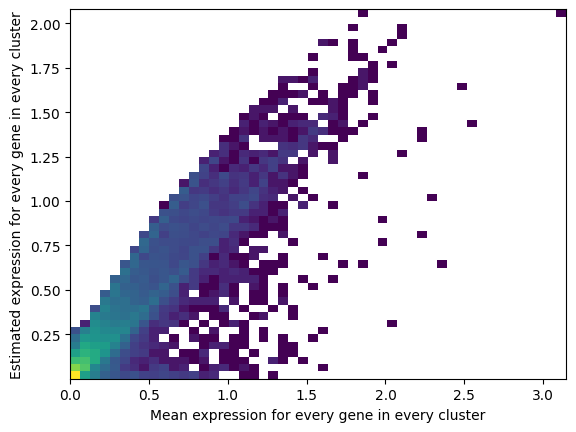

In [24]:
mod.plot_QC()

In [25]:
adata_ref.varm.keys()

KeysView(AxisArrays with keys: PCs, means_per_cluster_mu_fg, stds_per_cluster_mu_fg, q05_per_cluster_mu_fg, q95_per_cluster_mu_fg)

In [26]:
# export estimated expression in each cluster
if 'means_per_cluster_mu_fg' in adata_ref.varm.keys():
    inf_aver = adata_ref.varm['means_per_cluster_mu_fg'][[f'means_per_cluster_mu_fg_{i}'
                                    for i in adata_ref.uns['mod']['factor_names']]].copy()
else:
    inf_aver = adata_ref.var[[f'means_per_cluster_mu_fg_{i}'
                                    for i in adata_ref.uns['mod']['factor_names']]].copy()
inf_aver.columns = adata_ref.uns['mod']['factor_names']
inf_aver.iloc[0:5]

,B cells,Endothelial,Fibroblasts,Keratinocytes,Langerhans cells,Macrophages,Mast cells,Melanocytes,Monocytes,NK cells,Neural,Pericytes,Plasma cells,Smooth Muscle,T cells,cDC,pDC
A1BG,0.059979,0.018583,0.102582,0.002698,0.133521,0.068964,0.092066,0.214911,0.069565,0.036770,0.063589,0.106477,0.368177,0.049677,0.069903,0.154211,0.188909
A1BG-AS1,0.021634,0.003724,0.013824,0.000484,0.125966,0.010756,0.013616,0.043547,0.012412,0.011719,0.011524,0.017993,0.033347,0.024552,0.007660,0.009432,0.111761
A2M,0.023870,8.000330,0.129180,0.018114,0.055622,1.624264,0.006421,0.151256,0.008833,0.008853,0.124491,2.861745,0.030916,0.463410,0.008439,0.179410,0.031794
A2M-AS1,0.026108,0.010286,0.006850,0.000188,0.030476,0.005040,0.007645,0.005578,0.007538,0.008239,0.004434,0.007225,0.024278,0.034337,0.001979,0.001986,0.067154
A2ML1,0.018414,0.000471,0.000386,0.067814,0.024852,0.000667,0.001605,0.012093,0.005312,0.000691,0.002016,0.000214,0.018280,0.001496,0.000902,0.001100,0.026796


In [52]:
sample_list = ['HC01', 'HC02', 'HC03', 'HC05',
               'SSc4733', 'SSc4994', 'SSc5380', 'SSc5722',
               'SSc-HL01', 'SSc-HL05', 'SSc-HL06', 'SSc-HL11',
               'SSc-HL13', 'SSc-HL25', 'SSc-HL33', 'SSc-HL35']

In [ ]:
for sample in sample_list:
    adata_vis = sc.read_h5ad(f'../../results/spatial/filtered_data/{sample}.h5ad')
    
    # find mitochondria-encoded (MT) genes
    adata_vis.var['MT_gene'] = [gene.startswith('MT-') for gene in adata_vis.var_names]

    # remove MT genes for spatial mapping (keeping their counts in the object)
    adata_vis.obsm['MT'] = adata_vis[:, adata_vis.var['MT_gene'].values].X.toarray()
    adata_vis = adata_vis[:, ~adata_vis.var['MT_gene'].values]
    
    # find shared genes and subset both anndata and reference signatures
    intersect = np.intersect1d(adata_vis.var_names, inf_aver.index)
    adata_vis = adata_vis[:, intersect].copy()
    inf_aver_subset = inf_aver.loc[intersect, :].copy()
    
    # prepare anndata for cell2location model
    cell2location.models.Cell2location.setup_anndata(adata=adata_vis)
    
    # create and train the model
    mod = cell2location.models.Cell2location(
        adata_vis, 
        cell_state_df=inf_aver_subset,
        # the expected average cell abundance: tissue-dependent
        # hyper-prior which can be estimated from paired histology:
        N_cells_per_location=5,
        # hyperparameter controlling normalisation of
        # within-experiment variation in RNA detection:
        detection_alpha=20
    )
     
    mod.train(max_epochs=30000,
          # train using full data (batch_size=None)
          batch_size=None,
          # use all data points in training because
          # we need to estimate cell abundance at all locations
          train_size=1,
         )
    
    # In this section, we export the estimated cell abundance (summary of the posterior distribution).
    adata_vis = mod.export_posterior(
        adata_vis, sample_kwargs={'num_samples': 1000, 'batch_size': mod.adata.n_obs}
    )
    
    adata_vis.obs[adata_vis.uns['mod']['factor_names']] = adata_vis.obsm['q05_cell_abundance_w_sf']
    
    # normalize the estimated cell abundance
    df = adata_vis.obsm['q05_cell_abundance_w_sf']
    df = df.div(df.sum(axis=1), axis=0)
    df.columns = adata_vis.uns['mod']['factor_names']

    adata_vis.obsm['q05_cell_abundance_w_sf_normalized'] = df.div(df.sum(axis=1), axis=0)
    adata_vis.obs[adata_vis.uns['mod']['factor_names']] = adata_vis.obsm['q05_cell_abundance_w_sf_normalized']
    adata_vis.obs['pred_cell_type'] = df.idxmax(axis=1) 
    
    adata_vis.write(f'../../results/04_spatial/09_run_cell2location/{sample}.h5ad')
    adata_vis.obs.to_csv(f'../../results/04_spatial/09_run_cell2location/{sample}.csv')

Trainer will use only 1 of 2 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=2)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
Trainer will use only 1 of 2 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=2)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Epoch 30000/30000: 100%|██████████| 30000/30000 [35:25<00:00, 13.97it/s, v_num=1, elbo_train=9.49e+6]

`Trainer.fit` stopped: `max_epochs=30000` reached.


Epoch 30000/30000: 100%|██████████| 30000/30000 [35:25<00:00, 14.11it/s, v_num=1, elbo_train=9.49e+6]

Trainer will use only 1 of 2 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=2)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.



Sampling global variables, sample: 100%|██████████| 999/999 [00:14<00:00, 68.32it/s]


Trainer will use only 1 of 2 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=2)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
Trainer will use only 1 of 2 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=2)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Epoch 30000/30000: 100%|██████████| 30000/30000 [31:04<00:00, 17.56it/s, v_num=1, elbo_train=5.29e+6]

`Trainer.fit` stopped: `max_epochs=30000` reached.


Epoch 30000/30000: 100%|██████████| 30000/30000 [31:04<00:00, 16.09it/s, v_num=1, elbo_train=5.29e+6]

Trainer will use only 1 of 2 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=2)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.



Sampling global variables, sample: 100%|██████████| 999/999 [00:12<00:00, 81.03it/s]


Trainer will use only 1 of 2 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=2)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
Trainer will use only 1 of 2 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=2)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Epoch 30000/30000: 100%|██████████| 30000/30000 [31:01<00:00, 15.81it/s, v_num=1, elbo_train=1.91e+7]

`Trainer.fit` stopped: `max_epochs=30000` reached.


Epoch 30000/30000: 100%|██████████| 30000/30000 [31:01<00:00, 16.12it/s, v_num=1, elbo_train=1.91e+7]


Trainer will use only 1 of 2 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=2)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.


Sampling global variables, sample: 100%|██████████| 999/999 [00:13<00:00, 74.53it/s]


Trainer will use only 1 of 2 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=2)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
Trainer will use only 1 of 2 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=2)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Epoch 30000/30000: 100%|██████████| 30000/30000 [29:03<00:00, 17.32it/s, v_num=1, elbo_train=7.85e+6]

`Trainer.fit` stopped: `max_epochs=30000` reached.


Epoch 30000/30000: 100%|██████████| 30000/30000 [29:03<00:00, 17.21it/s, v_num=1, elbo_train=7.85e+6]

Trainer will use only 1 of 2 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=2)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.



Sampling global variables, sample: 100%|██████████| 999/999 [00:13<00:00, 76.70it/s]


Trainer will use only 1 of 2 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=2)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
Trainer will use only 1 of 2 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=2)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Epoch 30000/30000: 100%|██████████| 30000/30000 [28:54<00:00, 17.46it/s, v_num=1, elbo_train=9.4e+5] 

`Trainer.fit` stopped: `max_epochs=30000` reached.


Epoch 30000/30000: 100%|██████████| 30000/30000 [28:54<00:00, 17.30it/s, v_num=1, elbo_train=9.4e+5]

Trainer will use only 1 of 2 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=2)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.



Sampling global variables, sample: 100%|██████████| 999/999 [00:12<00:00, 82.09it/s]


Trainer will use only 1 of 2 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=2)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
Trainer will use only 1 of 2 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=2)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Epoch 30000/30000: 100%|██████████| 30000/30000 [32:29<00:00, 15.98it/s, v_num=1, elbo_train=1.37e+7]

`Trainer.fit` stopped: `max_epochs=30000` reached.


Epoch 30000/30000: 100%|██████████| 30000/30000 [32:29<00:00, 15.39it/s, v_num=1, elbo_train=1.37e+7]


Trainer will use only 1 of 2 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=2)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.


Sampling global variables, sample: 100%|██████████| 999/999 [00:13<00:00, 75.04it/s]


Trainer will use only 1 of 2 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=2)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
Trainer will use only 1 of 2 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=2)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Epoch 18470/30000:  62%|██████▏   | 18469/30000 [18:10<11:01, 17.42it/s, v_num=1, elbo_train=5.25e+6]